In [14]:
%pylab inline
import numpy as np

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


# DATA

In [105]:
SEQ_SIZE = 200

data = np.arange(-100, 100, 0.03)
data = np.sin(data)

def make_x_y(data, size=500):
    N = data.shape[0]
    
    data_x = np.zeros((N-size*2, size))
    data_y = np.zeros((N-size*2, size))
    for i, idx in enumerate(range(0, N-size*2)):
        x = data[idx: idx+size]
        y = data[idx+size: idx+size*2]
        
        data_x[idx, :x.shape[0]] = x
        data_y[idx, :y.shape[0]] = y
        
    data_x = np.asarray(data_x)
    data_y = np.asarray(data_y)
    
    data_x = data_x.reshape(-1, size, 1)
    data_y = data_y.reshape(-1, size, 1)
    
    # Shuffle
    permu = np.random.permutation(data_x.shape[0])
    data_x = data_x[permu]
    data_y = data_y[permu]
    return data_x, data_y

def make_diff_var(x, y):
    rand = np.random.randn(x.shape[0])
    for i in range(x.shape[0]):
        x[i] += rand[i]
        y[i] += rand[i]
    return x, y
        
data_x, data_y = make_x_y(data, size=SEQ_SIZE)
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, 
                                                    test_size=0.3, random_state=0)
test_x, test_y = make_diff_var(test_x, test_y)

print(data_x.shape, data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

(6267, 200, 1) (6267, 200, 1)
train_x: (4386, 200, 1)
train_y: (4386, 200, 1)
test_x: (1881, 200, 1)
test_y: (1881, 200, 1)


## Visualize Data

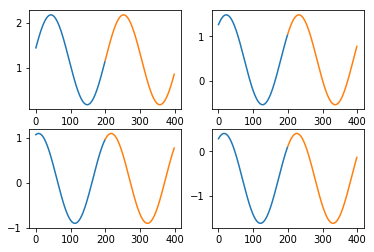

In [111]:
def visualize(data_x, data_y, seq_size=SEQ_SIZE):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
#             sp.get_xaxis().set_visible(False)
#             sp.get_yaxis().set_visible(False)
            
            r = np.random.randint(data_x.shape[0])
            sample_x = data_x[r]
            sample_y = data_y[r]
            
            sample_x = sample_x.reshape(sample_x.shape[0])
            sample_y = sample_y.reshape(sample_y.shape[0])
            tick_x = range(0, seq_size)
            tick_y = range(seq_size, seq_size*2)
            
            sp.plot(tick_x, sample_x)
            sp.plot(tick_y, sample_y)

visualize(test_x, test_y)

# RNN

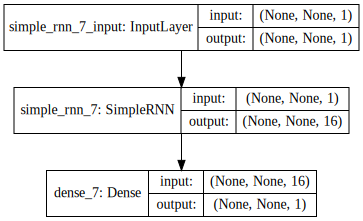

In [120]:
np.random.seed(0)

def create_model(lstm_out=10, optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(SimpleRNN(units=16, batch_input_shape=(None, None, 1), return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer, metrics=[mean_squared_error])
    return model

model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Train

In [121]:
model.fit(train_x, train_y, verbose=2, validation_data=(test_x, test_y), nb_epoch=30)

/usr/local/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4386 samples, validate on 1881 samples
Epoch 1/30
 - 9s - loss: 0.1014 - mean_squared_error: 0.1014 - val_loss: 0.5971 - val_mean_squared_error: 0.5971
Epoch 2/30
 - 8s - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.4666 - val_mean_squared_error: 0.4666
Epoch 3/30
 - 8s - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.3203 - val_mean_squared_error: 0.3203
Epoch 4/30
 - 8s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.2450 - val_mean_squared_error: 0.2450
Epoch 5/30
 - 8s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.2202 - val_mean_squared_error: 0.2202
Epoch 6/30
 - 8s - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.1999 - val_mean_squared_error: 0.1999
Epoch 7/30
 - 8s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.1848 - val_mean_squared_error: 0.1848
Epoch 8/30
 - 8s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.1696 - val_mean_squared_error: 0.1696
Epoch 9/30
 - 8s - loss: 0.0066 - mean_squared_e

mse: 0.063
r^2: 0.96


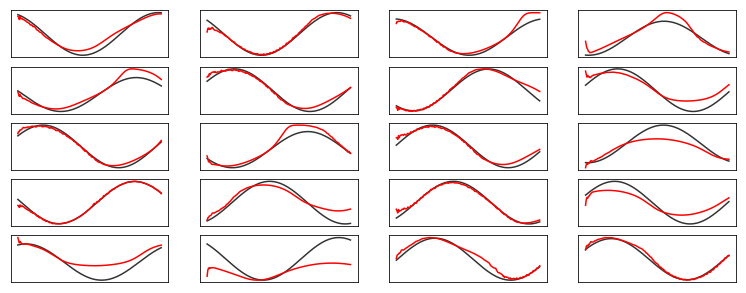

In [130]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, SIZE))
    y_pred = y_pred.reshape((-1, SIZE))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'mse: {error:.2}')
    print(f'r^2: {score:.2}')
    return score

def visualize_prediction(data_x, data_y):
    data_p = model.predict(data_x)
    data_x = data_x.reshape((-1, SIZE))
    data_y = data_y.reshape((-1, SIZE))
    data_p = data_p.reshape((-1, SIZE))
    accuracy(data_y, data_p)
        
    fig, sub_plots = subplots(5, 4)
    fig.set_figwidth(13)
    fig.set_figheight(5)
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
        
            idx = np.random.randint(data_x.shape[0])
            
            sp.plot(data_y[idx], color='#333333')
            sp.plot(data_p[idx], color='red')


visualize_prediction(test_x, test_y)